In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from openTSNE.affinity import Affinities
from vis_utils.tsne_wrapper import TSNEwrapper

import sys
sys.path.append("..")
from scripts.utils import get_path
from vis_utils.loaders import  load_dataset
from vis_utils.utils import  save_dict, load_dict
from vis_utils.plot import plot_scatter


env: CUDA_VISIBLE_DEVICES=1


In [2]:
# set up matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

In [3]:
root_path = get_path("data")
fig_path = get_path("figures")

In [7]:
dataset = "mnist"
k=15
seed = 0
seeds = [0, 1, 2]
perplexity = 2*k # has no effect as sknn_graph is used
rescale_tsne = True
log_kl = False
log_embds = False
log_Z = True


In [8]:
# get data
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset)

In [ ]:
if rescale_tsne:
    pca_tsne = pca2 / np.std(pca2[:, 0]) / 10000
else:
    pca_tsne = pca2
affinities_tSNE = Affinities()
affinities_tSNE.P = (sknn_graph / sknn_graph.sum()).tocsr()

# t-SNE

In [9]:
n_early_epochs = 250
n_epochs = 500
tsne_data_list = []
for s in seeds:
    file_name = os.path.join(root_path,
                             "mnist",
                             f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{s}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.pkl")
    try:
        tsne_data = load_dict(file_name)
    except FileNotFoundError:
        tsne = TSNEwrapper(perplexity=perplexity,
                           metric="euclidean",
                           n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                           random_state=s,
                           verbose=True,
                           n_iter = n_epochs,
                           early_exaggeration_iter = n_early_epochs,
                           callbacks_every_iters=1,
                           log_kl=log_kl,
                           log_embds=log_embds,
                           log_Z=log_Z,
                           initialization=pca_tsne)
        embd = tsne.fit_transform(x, affinities=affinities_tSNE)
        save_dict(tsne.aux_data, file_name)
        tsne_data = tsne.aux_data
    tsne_data_list.append(tsne_data)



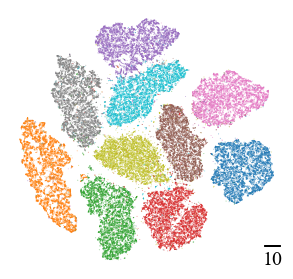

In [11]:
plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), tsne_data_list[0]["embd"], y )

plt.savefig(os.path.join(fig_path,
                         f"tsne_mnist_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [12]:
final_Z = np.array([tsne_data["Zs"][-1].detach().cpu().numpy() for tsne_data in tsne_data_list])
print(f"Mean: {'{:.2E}'.format(final_Z.mean())}")
print(f"Std: {final_Z.std()}")


Mean: 8.13E+06
Std: 0.0


Other than in initialization and kNN graph computation, tSNE does not depend on a random seed.

# No early exaggeration

In [20]:
n_early_epochs = 0
n_epochs = 750

tsne_data_list = []
for s in seeds:
    file_name = os.path.join(root_path,
                             "mnist",
                             f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{s}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.pkl")
    try:
        tsne_data = load_dict(file_name)
    except FileNotFoundError:
        tsne = TSNEwrapper(perplexity=perplexity,
                           metric="euclidean",
                           n_jobs=5, # n_jobs=-10 does not work well, the cell does not print anything
                           random_state=s,
                           verbose=True,
                           n_iter = n_epochs,
                           early_exaggeration_iter = n_early_epochs,
                           callbacks_every_iters=1,
                           log_kl=log_kl,
                           log_embds=log_embds,
                           log_Z=log_Z,
                           initialization=pca_tsne)
        embd = tsne.fit_transform(x, affinities=affinities_tSNE)

        save_dict(tsne.aux_data, file_name)
        tsne_data = tsne.aux_data
    tsne_data_list.append(tsne_data)


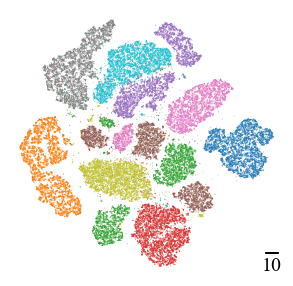

In [14]:
plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), tsne_data_list[0]["embd"], y )
plt.savefig(os.path.join(fig_path,
                         f"tsne_mnist_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [15]:
final_Z = np.array([tsne_data["Zs"][-1].detach().cpu().numpy() for tsne_data in tsne_data_list])
print(f"Mean: {'{:.2E}'.format(final_Z.mean())}")
print(f"Std: {final_Z.std()}")


Mean: 6.25E+06
Std: 0.0


## random init

In [16]:
n_early_epochs = 0
n_epochs = 750

np.random.seed(seed)
init = np.random.randn(len(x), 2)
if rescale_tsne:
    init = init / np.std(init[:, 0]) / 10000

In [17]:
log_kl = False
log_embds = False
log_Z = True
file_name = os.path.join(root_path,
                         "mnist",
                         f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_init_random_rescale_{rescale_tsne}.pkl")

In [18]:
try:
    tsne_data = load_dict(file_name)
except FileNotFoundError:
    tsne = TSNEwrapper(perplexity=perplexity,
                       metric="euclidean",
                       n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                       random_state=seed,
                       verbose=True,
                       n_iter = n_epochs,
                       early_exaggeration_iter = n_early_epochs,
                       callbacks_every_iters=1,
                       log_kl=log_kl,
                       log_embds=log_embds,
                       log_Z=log_Z,
                       initialization=init)
    embd = tsne.fit_transform(x, affinities=affinities_tSNE)


    save_dict(tsne.aux_data, file_name)
    tsne_data = tsne.aux_data

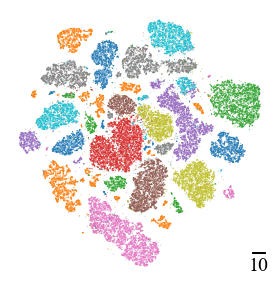

In [19]:
epoch = -1

plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), tsne_data["embd"], y )
plt.savefig(os.path.join(fig_path,
                         f"tsne_mnist_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_random_rescale_{rescale_tsne}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor='white')